In [1]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 66.0 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 600MB/s]


In [8]:
! unzip walmart-recruiting-store-sales-forecasting.zip

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [10]:
stores = pd.read_csv('stores.csv')

# Load and extract zipped files
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
train = pd.read_csv('train.csv')

with zipfile.ZipFile('test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
test = pd.read_csv('test.csv')

with zipfile.ZipFile('features.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
features = pd.read_csv('features.csv')

print("✅ All datasets loaded successfully!")

✅ All datasets loaded successfully!


In [11]:
# Basic dataset overview
datasets = {
    'stores': stores,
    'train': train,
    'test': test,
    'features': features
}

print("📊 DATASET OVERVIEW")
print("=" * 50)
for name, df in datasets.items():
    print(f"{name.upper()}:")
    print(f"  Shape: {df.shape}")
    print(f"  Columns: {list(df.columns)}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print()

📊 DATASET OVERVIEW
STORES:
  Shape: (45, 3)
  Columns: ['Store', 'Type', 'Size']
  Memory: 0.00 MB

TRAIN:
  Shape: (421570, 5)
  Columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
  Memory: 36.99 MB

TEST:
  Shape: (115064, 4)
  Columns: ['Store', 'Dept', 'Date', 'IsHoliday']
  Memory: 9.22 MB

FEATURES:
  Shape: (8190, 12)
  Columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
  Memory: 1.16 MB



In [12]:
print("🏪 STORES DATASET")
print("=" * 30)
print(f"Number of stores: {stores['Store'].nunique()}")
print(f"Store types: {stores['Type'].value_counts().to_dict()}")
print(f"Size range: {stores['Size'].min():,} - {stores['Size'].max():,} sq ft")

# Display stores data
display(stores.head())

# Store size by type
print("\nStore size statistics by type:")
display(stores.groupby('Type')['Size'].describe())

🏪 STORES DATASET
Number of stores: 45
Store types: {'A': 22, 'B': 17, 'C': 6}
Size range: 34,875 - 219,622 sq ft


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875



Store size statistics by type:


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.727273,49392.621098,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.705882,32371.137916,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.666667,1304.145033,39690.0,39745.00,39910.0,40774.0,42988.0


In [13]:
# 2. TRAINING DATA ANALYSIS
# Convert dates
train['Date'] = pd.to_datetime(train['Date'])

print("📈 TRAINING DATASET")
print("=" * 30)
print(f"Date range: {train['Date'].min()} to {train['Date'].max()}")
print(f"Stores: {train['Store'].nunique()}")
print(f"Departments: {train['Dept'].nunique()}")
print(f"Total records: {len(train):,}")
print(f"Holiday weeks: {train['IsHoliday'].sum():,}")
print(f"Sales range: ${train['Weekly_Sales'].min():,.2f} to ${train['Weekly_Sales'].max():,.2f}")

# Sample data
display(train.head(10))

# Missing values check
print("\nMissing values:")
print(train.isnull().sum())

📈 TRAINING DATASET
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
Stores: 45
Departments: 81
Total records: 421,570
Holiday weeks: 29,661
Sales range: $-4,988.94 to $693,099.36


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False



Missing values:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


In [14]:
# 3. SALES PATTERNS
print("💰 SALES ANALYSIS")
print("=" * 25)

# Basic statistics
print(f"Mean weekly sales: ${train['Weekly_Sales'].mean():,.2f}")
print(f"Median weekly sales: ${train['Weekly_Sales'].median():,.2f}")

# Holiday vs non-holiday sales
holiday_comparison = train.groupby('IsHoliday')['Weekly_Sales'].agg(['mean', 'median', 'count'])
print("\nHoliday vs Non-Holiday Sales:")
display(holiday_comparison)

# Top departments by sales
top_depts = train.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 departments by average sales:")
display(top_depts)

💰 SALES ANALYSIS
Mean weekly sales: $15,981.26
Median weekly sales: $7,612.03

Holiday vs Non-Holiday Sales:


,mean,median,count
IsHoliday,,,
False,15901.445069,7589.95,391909
True,17035.823187,7947.74,29661



Top 10 departments by average sales:


,Weekly_Sales
Dept,
92,75204.870531
95,69824.423080
38,61090.619568
72,50566.515417
65,45441.706224
90,45232.084488
40,44900.702727
2,43607.020113
91,33687.910758


In [15]:
# 4. FEATURES DATA ANALYSIS
features['Date'] = pd.to_datetime(features['Date'])

print("🌡️ FEATURES DATASET")
print("=" * 30)
print(f"Date range: {features['Date'].min()} to {features['Date'].max()}")
print(f"Stores covered: {features['Store'].nunique()}")

# Sample features
display(features.head())

# Missing data analysis
print("\nMissing values:")
missing_data = features.isnull().sum()
missing_pct = (missing_data / len(features)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
})
display(missing_df[missing_df['Missing Count'] > 0])

🌡️ FEATURES DATASET
Date range: 2010-02-05 00:00:00 to 2013-07-26 00:00:00
Stores covered: 45


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False



Missing values:


,Missing Count,Missing %
MarkDown1,4158,50.769231
MarkDown2,5269,64.334554
MarkDown3,4577,55.885226
MarkDown4,4726,57.704518
MarkDown5,4140,50.549451
CPI,585,7.142857
Unemployment,585,7.142857


In [16]:
# 5. MARKDOWN DATA AVAILABILITY
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

print("🔖 MARKDOWN DATA AVAILABILITY")
print("=" * 35)
for col in markdown_cols:
    non_null = features[col].notna().sum()
    pct = (non_null / len(features)) * 100
    print(f"{col}: {non_null:,} records ({pct:.1f}%)")

# When markdown data becomes available
features_with_markdown = features[features[markdown_cols].notna().any(axis=1)]
print(f"\nFirst markdown data: {features_with_markdown['Date'].min()}")
print(f"As stated: Should be after Nov 2011 ✓")

🔖 MARKDOWN DATA AVAILABILITY
MarkDown1: 4,032 records (49.2%)
MarkDown2: 2,921 records (35.7%)
MarkDown3: 3,613 records (44.1%)
MarkDown4: 3,464 records (42.3%)
MarkDown5: 4,050 records (49.5%)

First markdown data: 2011-11-11 00:00:00
As stated: Should be after Nov 2011 ✓


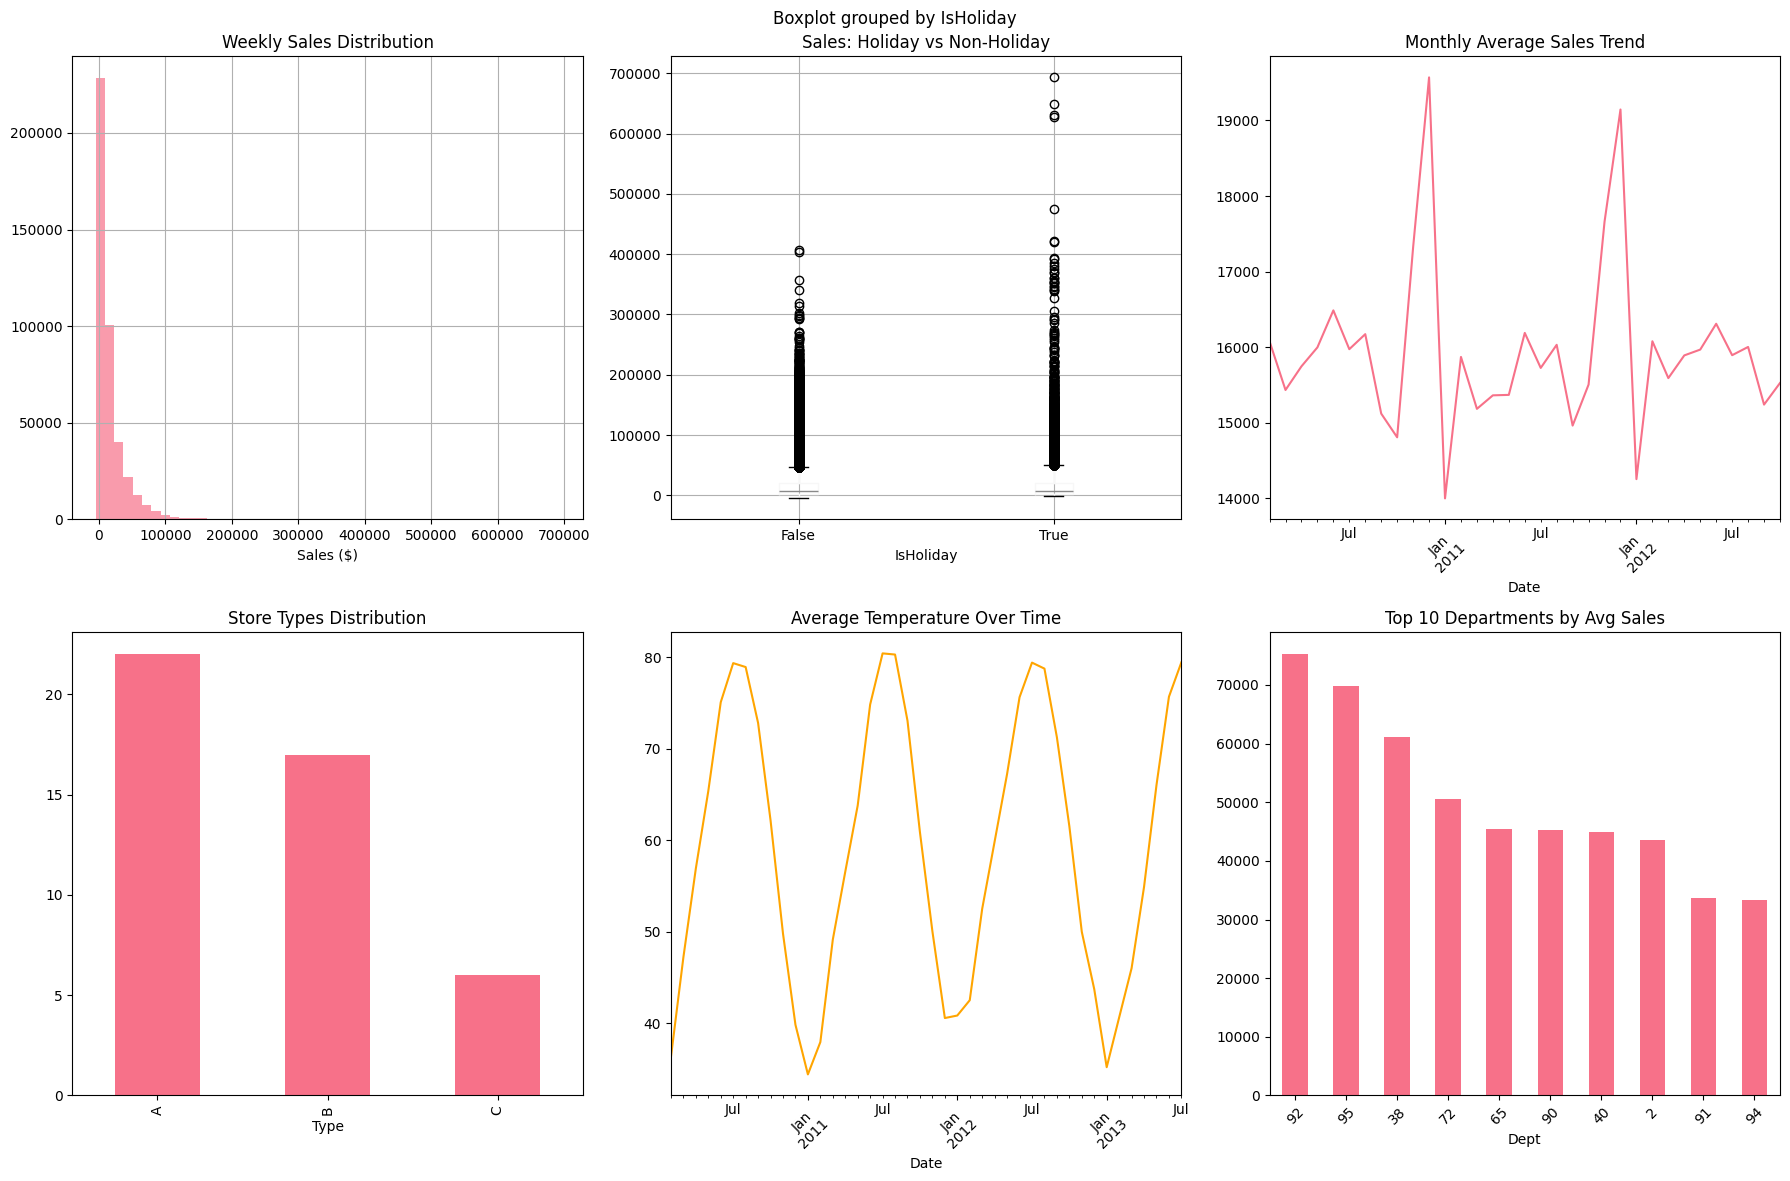

In [17]:
# 6. VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sales distribution
train['Weekly_Sales'].hist(bins=50, ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Weekly Sales Distribution')
axes[0,0].set_xlabel('Sales ($)')

# Holiday vs non-holiday
train.boxplot(column='Weekly_Sales', by='IsHoliday', ax=axes[0,1])
axes[0,1].set_title('Sales: Holiday vs Non-Holiday')

# Sales over time (monthly average)
monthly_sales = train.groupby(train['Date'].dt.to_period('M'))['Weekly_Sales'].mean()
monthly_sales.plot(ax=axes[0,2])
axes[0,2].set_title('Monthly Average Sales Trend')
axes[0,2].tick_params(axis='x', rotation=45)

# Store types distribution
stores['Type'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Store Types Distribution')

# Temperature over time
temp_monthly = features.groupby(features['Date'].dt.to_period('M'))['Temperature'].mean()
temp_monthly.plot(ax=axes[1,1], color='orange')
axes[1,1].set_title('Average Temperature Over Time')
axes[1,1].tick_params(axis='x', rotation=45)

# Top departments
top_depts.plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Top 10 Departments by Avg Sales')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
# 7. HOLIDAY ANALYSIS
print("🎉 HOLIDAY WEEK ANALYSIS")
print("=" * 30)

# Holiday dates from the problem description
holiday_dates = {
    'Super Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23'],
    'Christmas': ['2010-12-31', '2011-12-30', '2012-12-28']
}

# Check which holidays are in our data
train_dates = set(train['Date'].dt.strftime('%Y-%m-%d'))

for holiday, dates in holiday_dates.items():
    available = [date for date in dates if date in train_dates]
    print(f"{holiday}: {len(available)}/{len(dates)} dates in training data")
    if available:
        print(f"  Available: {available}")

🎉 HOLIDAY WEEK ANALYSIS
Super Bowl: 3/3 dates in training data
  Available: ['2010-02-12', '2011-02-11', '2012-02-10']
Labor Day: 3/3 dates in training data
  Available: ['2010-09-10', '2011-09-09', '2012-09-07']
Thanksgiving: 2/3 dates in training data
  Available: ['2010-11-26', '2011-11-25']
Christmas: 2/3 dates in training data
  Available: ['2010-12-31', '2011-12-30']


In [20]:
!pip install mlflow xgboost scikit-learn dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [21]:
# Basic XGBoost Model with MLflow Pipeline + Dagshub
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
import mlflow
import mlflow.xgboost
import mlflow.sklearn
import dagshub
import zipfile
import warnings
warnings.filterwarnings('ignore')

print("📦 Libraries imported successfully!")

📦 Libraries imported successfully!


In [22]:
# Dagshub + MLflow Setup
import os

# Initialize Dagshub (replace with your repo details)
dagshub.init(repo_owner="konstantine25b", repo_name="Walmart-Recruiting---Store-Sales-Forecasting", mlflow=True)

# Set experiment
experiment_name = "XGBoost_Training_easy_kosa"

# Create or get experiment
try:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"✅ Created new experiment: {experiment_name}")
except:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id
    print(f"✅ Using existing experiment: {experiment_name}")

mlflow.set_experiment(experiment_name)
print(f"🔗 MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"🎯 Dagshub tracking enabled!")

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=4daa8a0e-daba-456e-9230-7f1674685af9&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a4616a46c658d5f5056e0ca94fe10b690b1f17caf7249ceeb5e8713ffcc69e9c




Accessing as konstantine25b

Initialized MLflow to track repo "konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting"

Repository konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting initialized!

✅ Created new experiment: XGBoost_Training_easy_kosa
🔗 MLflow tracking URI: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow
🎯 Dagshub tracking enabled!


# Data

In [25]:
# Continue with data loading (ONLY train.csv and stores.csv)
print("📊 Loading datasets...")

# Load stores
stores = pd.read_csv('stores.csv')

# Load training data
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
train = pd.read_csv('train.csv')

# Load test data
with zipfile.ZipFile('test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
test = pd.read_csv('test.csv')

print(f"✅ Data loaded - Train: {train.shape}, Test: {test.shape}")
print("📝 Note: Using ONLY train.csv and stores.csv (no features.csv)")

📊 Loading datasets...
✅ Data loaded - Train: (421570, 5), Test: (115064, 4)
📝 Note: Using ONLY train.csv and stores.csv (no features.csv)


In [26]:
# Custom Pipeline Class for XGBoost
class BasicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}
        self.fill_values = {}

    def fit(self, X, y=None):
        # Store fill values for numeric columns
        for col in X.columns:
            if X[col].dtype in ['float64', 'int64']:
                self.fill_values[col] = X[col].median()
            else:
                mode_val = X[col].mode()
                self.fill_values[col] = mode_val[0] if len(mode_val) > 0 else 0
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # Fill missing values
        for col in X_transformed.columns:
            if col in self.fill_values:
                X_transformed[col] = X_transformed[col].fillna(self.fill_values[col])

        return X_transformed

print("🔧 Pipeline components ready!")

🔧 Pipeline components ready!


In [28]:
# Basic Data Preparation Run (ONLY train.csv + stores.csv, no test.csv)
with mlflow.start_run(run_name="XGBoost_Basic_Prep") as run:

    print(f"🔄 Starting prep run: {run.info.run_id}")

    # Log parameters
    mlflow.log_param("data_prep_strategy", "train_only_split")
    mlflow.log_param("missing_value_strategy", "median_fill")
    mlflow.log_param("branch", "kosa1")
    mlflow.log_param("datasets_used", "train.csv, stores.csv")
    mlflow.log_param("test_csv_used", "No - internal split only")

    # Convert dates
    train['Date'] = pd.to_datetime(train['Date'])

    # Merge with stores info ONLY
    train_full = train.merge(stores, on='Store', how='left')

    # Feature selection (ONLY from train + stores)
    feature_cols = ['Store', 'Dept', 'Size']

    # Handle categorical Type column
    le_type = LabelEncoder()
    train_full['Type_encoded'] = le_type.fit_transform(train_full['Type'].fillna('B'))
    feature_cols.append('Type_encoded')

    # Add IsHoliday
    train_full['IsHoliday_encoded'] = train_full['IsHoliday'].astype(int)
    feature_cols.append('IsHoliday_encoded')

    # Extract date features
    train_full['Year'] = train_full['Date'].dt.year
    train_full['Month'] = train_full['Date'].dt.month
    train_full['Week'] = train_full['Date'].dt.isocalendar().week
    train_full['DayOfYear'] = train_full['Date'].dt.dayofyear

    feature_cols.extend(['Year', 'Month', 'Week', 'DayOfYear'])

    # Prepare final dataset
    X = train_full[feature_cols].copy()
    y = train_full['Weekly_Sales'].copy()

    # Handle missing values (should be minimal with this simple setup)
    for col in feature_cols:
        if X[col].isnull().sum() > 0:
            if X[col].dtype in ['float64', 'int64']:
                fill_value = X[col].median()
            else:
                fill_value = X[col].mode()[0] if len(X[col].mode()) > 0 else 0

            X[col] = X[col].fillna(fill_value)

    # Split into train/validation/test sets
    # First split: 80% train, 20% temp
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Second split: 75% of remaining for train, 25% for validation
    # This gives us 60% train, 20% val, 20% test
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, test_size=0.25, random_state=42, shuffle=True
    )

    # Log data info
    mlflow.log_metric("total_samples", len(X))
    mlflow.log_metric("train_samples", len(X_train))
    mlflow.log_metric("val_samples", len(X_val))
    mlflow.log_metric("test_samples", len(X_test))
    mlflow.log_metric("features_count", len(feature_cols))
    mlflow.log_metric("missing_values_after_prep", X.isnull().sum().sum())
    mlflow.log_metric("stores_count", train_full['Store'].nunique())
    mlflow.log_metric("departments_count", train_full['Dept'].nunique())

    # Log split ratios
    mlflow.log_param("train_ratio", len(X_train) / len(X))
    mlflow.log_param("val_ratio", len(X_val) / len(X))
    mlflow.log_param("test_ratio", len(X_test) / len(X))

    print(f"✅ Data prepared - Features: {len(feature_cols)}")
    print(f"📋 Feature columns: {feature_cols}")
    print(f"📊 Total samples: {len(X):,}")
    print(f"📊 Train samples: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"📊 Validation samples: {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
    print(f"📊 Test samples: {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
    print(f"🏪 Stores: {train_full['Store'].nunique()}")
    print(f"🏬 Departments: {train_full['Dept'].nunique()}")
    print(f"🎯 Target range: ${y.min():,.2f} to ${y.max():,.2f}")

🔄 Starting prep run: 2e5eeb8d05994410b3541f567504194c
✅ Data prepared - Features: 9
📋 Feature columns: ['Store', 'Dept', 'Size', 'Type_encoded', 'IsHoliday_encoded', 'Year', 'Month', 'Week', 'DayOfYear']
📊 Total samples: 421,570
📊 Train samples: 252,942 (60.0%)
📊 Validation samples: 84,314 (20.0%)
📊 Test samples: 84,314 (20.0%)
🏪 Stores: 45
🏬 Departments: 81
🎯 Target range: $-4,988.94 to $693,099.36
🏃 View run XGBoost_Basic_Prep at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0/runs/2e5eeb8d05994410b3541f567504194c
🧪 View experiment at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0


In [31]:
# Custom WMAE metric function
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """
    Calculate Weighted Mean Absolute Error (WMAE)

    WMAE = Σ(w_i * |y_i - ŷ_i|) / Σ(w_i)

    where:
    - w_i = 5 if holiday week, 1 otherwise
    - y_i = actual sales
    - ŷ_i = predicted sales
    """
    weighted_errors = weights * np.abs(y_true - y_pred)
    return weighted_errors.sum() / weights.sum()

print("🎯 WMAE metric function created!")

🎯 WMAE metric function created!


In [32]:
# Updated XGBoost Training Run with WMAE
with mlflow.start_run(run_name="XGBoost_Basic_Training_WMAE") as run:

    print(f"🔄 Starting training run with WMAE: {run.info.run_id}")

    # Create pipeline (same as before)
    pipeline = Pipeline([
        ('preprocessor', BasicPreprocessor()),
        ('regressor', xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            objective='reg:squarederror',
            verbosity=0
        ))
    ])

    # Log parameters
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("features_used", len(feature_cols))
    mlflow.log_param("random_state", 42)
    mlflow.log_param("data_source", "train_only_internal_split")
    mlflow.log_param("split_strategy", "60_20_20")
    mlflow.log_param("evaluation_metric", "WMAE")

    # Train pipeline
    print("🚀 Training XGBoost model...")
    pipeline.fit(X_train, y_train)

    # Make predictions on all sets
    y_train_pred = pipeline.predict(X_train)
    y_val_pred = pipeline.predict(X_val)
    y_test_pred = pipeline.predict(X_test)

    # Get holiday weights for each set
    # We need to get the original holiday flags back
    train_indices = X_train.index
    val_indices = X_val.index
    test_indices = X_test.index

    # Get holiday flags from original data
    train_holidays = train_full.loc[train_indices, 'IsHoliday']
    val_holidays = train_full.loc[val_indices, 'IsHoliday']
    test_holidays = train_full.loc[test_indices, 'IsHoliday']

    # Create weights (5 for holiday, 1 for non-holiday)
    train_weights = np.where(train_holidays, 5, 1)
    val_weights = np.where(val_holidays, 5, 1)
    test_weights = np.where(test_holidays, 5, 1)

    # Calculate traditional MAE and RMSE
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Calculate WMAE (competition metric!)
    train_wmae = weighted_mean_absolute_error(y_train, y_train_pred, train_weights)
    val_wmae = weighted_mean_absolute_error(y_val, y_val_pred, val_weights)
    test_wmae = weighted_mean_absolute_error(y_test, y_test_pred, test_weights)

    # Log all metrics
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("val_rmse", val_rmse)
    mlflow.log_metric("test_rmse", test_rmse)

    # Log WMAE (most important!)
    mlflow.log_metric("train_wmae", train_wmae)
    mlflow.log_metric("val_wmae", val_wmae)
    mlflow.log_metric("test_wmae", test_wmae)

    # Log holiday statistics
    mlflow.log_metric("train_holiday_weeks", train_holidays.sum())
    mlflow.log_metric("val_holiday_weeks", val_holidays.sum())
    mlflow.log_metric("test_holiday_weeks", test_holidays.sum())
    mlflow.log_metric("train_holiday_pct", train_holidays.mean() * 100)
    mlflow.log_metric("val_holiday_pct", val_holidays.mean() * 100)
    mlflow.log_metric("test_holiday_pct", test_holidays.mean() * 100)

    # Log model
    print("💾 Logging model to MLflow...")
    try:
        mlflow.sklearn.log_model(pipeline, "xgboost_pipeline")
        print("✅ Model logged successfully!")
    except Exception as e:
        print(f"⚠️ Model logging issue: {e}")

    # Save feature info
    feature_info = {
        'feature_columns': feature_cols,
        'feature_count': len(feature_cols),
        'data_sources': ['train.csv', 'stores.csv'],
        'split_strategy': '60% train, 20% val, 20% test',
        'evaluation_metric': 'WMAE (Weighted MAE)',
        'holiday_weight': 5,
        'normal_weight': 1,
        'model_type': 'XGBoost',
        'run_id': run.info.run_id
    }
    mlflow.log_dict(feature_info, "feature_info.json")

    # Save model locally
    import joblib
    joblib.dump(pipeline, 'xgboost_wmae_pipeline.pkl')
    mlflow.log_artifact('xgboost_wmae_pipeline.pkl')

    print(f"✅ Training completed with WMAE evaluation!")
    print(f"\n📊 TRADITIONAL METRICS:")
    print(f"   Training MAE: ${train_mae:,.2f}")
    print(f"   Validation MAE: ${val_mae:,.2f}")
    print(f"   Test MAE: ${test_mae:,.2f}")

    print(f"\n🎯 COMPETITION METRICS (WMAE):")
    print(f"   Training WMAE: ${train_wmae:,.2f}")
    print(f"   Validation WMAE: ${val_wmae:,.2f}")
    print(f"   Test WMAE: ${test_wmae:,.2f}")

    print(f"\n🎉 HOLIDAY STATISTICS:")
    print(f"   Train holiday weeks: {train_holidays.sum():,} ({train_holidays.mean()*100:.1f}%)")
    print(f"   Val holiday weeks: {val_holidays.sum():,} ({val_holidays.mean()*100:.1f}%)")
    print(f"   Test holiday weeks: {test_holidays.sum():,} ({test_holidays.mean()*100:.1f}%)")

    # Show the impact of weighting
    wmae_impact = test_wmae - test_mae
    print(f"\n⚖️ WEIGHTING IMPACT:")
    print(f"   Regular MAE: ${test_mae:,.2f}")
    print(f"   Weighted MAE: ${test_wmae:,.2f}")
    print(f"   Difference: ${wmae_impact:,.2f} ({'higher' if wmae_impact > 0 else 'lower'} due to holiday weighting)")

🔄 Starting training run with WMAE: 0f1276d7c85f426cb849c646a6d72ab5
🚀 Training XGBoost model...


2025/06/23 14:02:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


💾 Logging model to MLflow...
⚠️ Model logging issue: INTERNAL_ERROR: Response: {'error': 'unsupported endpoint, please contact support@dagshub.com'}
✅ Training completed with WMAE evaluation!

📊 TRADITIONAL METRICS:
   Training MAE: $3,886.66
   Validation MAE: $3,944.35
   Test MAE: $3,966.39

🎯 COMPETITION METRICS (WMAE):
   Training WMAE: $4,037.02
   Validation WMAE: $4,163.80
   Test WMAE: $4,110.79

🎉 HOLIDAY STATISTICS:
   Train holiday weeks: 17,793 (7.0%)
   Val holiday weeks: 5,882 (7.0%)
   Test holiday weeks: 5,986 (7.1%)

⚖️ WEIGHTING IMPACT:
   Regular MAE: $3,966.39
   Weighted MAE: $4,110.79
   Difference: $144.39 (higher due to holiday weighting)
🏃 View run XGBoost_Basic_Training_WMAE at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0/runs/0f1276d7c85f426cb849c646a6d72ab5
🧪 View experiment at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0


In [33]:
# Enhanced Evaluation with WMAE Analysis
with mlflow.start_run(run_name="XGBoost_WMAE_Evaluation") as run:

    print(f"🔄 Starting WMAE evaluation run: {run.info.run_id}")

    # Detailed analysis of holiday vs non-holiday performance
    test_holiday_mask = test_holidays.values
    test_normal_mask = ~test_holiday_mask

    # Split predictions by holiday status
    y_test_holiday = y_test.values[test_holiday_mask]
    y_pred_holiday = y_test_pred[test_holiday_mask]
    y_test_normal = y_test.values[test_normal_mask]
    y_pred_normal = y_test_pred[test_normal_mask]

    # Calculate separate MAE for holiday vs normal weeks
    if len(y_test_holiday) > 0:
        holiday_mae = mean_absolute_error(y_test_holiday, y_pred_holiday)
        mlflow.log_metric("test_holiday_mae", holiday_mae)
    else:
        holiday_mae = 0

    if len(y_test_normal) > 0:
        normal_mae = mean_absolute_error(y_test_normal, y_pred_normal)
        mlflow.log_metric("test_normal_mae", normal_mae)
    else:
        normal_mae = 0

    # Log detailed metrics
    mlflow.log_metric("test_wmae_final", test_wmae)
    mlflow.log_metric("test_mae_final", test_mae)
    mlflow.log_metric("wmae_vs_mae_difference", test_wmae - test_mae)

    # Create detailed comparison
    comparison_df = pd.DataFrame({
        'Actual': y_test.values[:200],
        'Predicted': y_test_pred[:200],
        'Error': y_test.values[:200] - y_test_pred[:200],
        'Abs_Error': np.abs(y_test.values[:200] - y_test_pred[:200]),
        'Is_Holiday': test_holidays.values[:200],
        'Weight': test_weights[:200],
        'Weighted_Error': test_weights[:200] * np.abs(y_test.values[:200] - y_test_pred[:200])
    })

    # Save detailed comparison
    comparison_df.to_csv('wmae_test_comparison.csv', index=False)
    mlflow.log_artifact('wmae_test_comparison.csv')

    print(f"✅ WMAE evaluation completed!")
    print(f"\n📊 FINAL WMAE RESULTS:")
    print(f"   Competition Metric (WMAE): ${test_wmae:,.2f}")
    print(f"   Regular MAE: ${test_mae:,.2f}")
    print(f"   Holiday weeks MAE: ${holiday_mae:,.2f}")
    print(f"   Normal weeks MAE: ${normal_mae:,.2f}")
    print(f"\n🎯 This WMAE score is your competition benchmark!")

🔄 Starting WMAE evaluation run: 64148cb3468c4f7cad0bf2c01c980fc5
✅ WMAE evaluation completed!

📊 FINAL WMAE RESULTS:
   Competition Metric (WMAE): $4,110.79
   Regular MAE: $3,966.39
   Holiday weeks MAE: $4,619.24
   Normal weeks MAE: $3,916.50

🎯 This WMAE score is your competition benchmark!
🏃 View run XGBoost_WMAE_Evaluation at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0/runs/64148cb3468c4f7cad0bf2c01c980fc5
🧪 View experiment at: https://dagshub.com/konstantine25b/Walmart-Recruiting---Store-Sales-Forecasting.mlflow/#/experiments/0
